In [10]:
import boto3 , re , datetime , argparse
import zipfile , os , shutil
import pandas as pd
from pathlib import Path
import yaml

with open('configs/confidential/aws.yaml' , 'r') as f:
    aws_info = yaml.load(f , Loader=yaml.FullLoader)
    aws_access_key_id = aws_info['aws_access_key_id']
    aws_secret_access_key = aws_info['aws_secret_access_key']

session = boto3.Session(aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name='cn-north-1')
s3 = session.resource('s3')
bucket = s3.Bucket('datayes-data')
zip_path = Path('data/Miscellaneous/JSMinute')

def fut_list():
    ...

def idx_list():
    ...

def cvt_list():
    ...

def etf_list():
    path = 'data/DataBase/DB_information_ts/mutual_fund_info.feather'
    fund_list = pd.read_feather(path)
    fund_list[fund_list['market'] == 'E']

def download_one_day(date , file):
    zip_file_path = zip_path.joinpath(f'min.{date}.zip')
    if zip_file_path.exists(): return
    bucket.download_file(file.key , zip_file_path)

def transform_one_day(date):
    target_path = zip_path.joinpath(f'min/min.{date}.feather')
    target_path.parent.mkdir(parents=True , exist_ok=True)
    if target_path.exists(): return
    zip_file_path = zip_path.joinpath(f'min.{date}.zip')
    txt_file_path = f'equity_pricemin{date}.txt'

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: 
        zip_ref.extract(txt_file_path , zip_path)
        df = pd.read_csv(zip_path.joinpath(txt_file_path) , sep = '\t')
        zip_path.joinpath(txt_file_path).unlink()
    df.to_feather(target_path)
    return df

def kline_download(start = 20100104 , end = 20241226):
    os.makedirs(zip_path , exist_ok=True)

    filedate = lambda x:int(re.findall(r'(\d{8})', x.key)[-1])
    filefilter = lambda x:(x.key.endswith('.zip') and os.path.basename(x.key).startswith('equity_pricemin'))
    print(start , end)
    if start <= 20230328 and end <= 20230328:
        file_list = [f for f in bucket.objects.filter(Prefix = 'equity_pricemin/') if filefilter(f)]
        file_list = [f for f in file_list if filedate(f) >= start and filedate(f) <= end]
    elif start > 20230328 and end > 20230328:
        file_list = [f for f in bucket.objects.filter(Prefix = 'snapshot/L1_services_equd_min/') if filefilter(f)]
        file_list = [f for f in file_list if filedate(f) >= start and filedate(f) <= end]
    else:
        _file_list_1 = [f for f in bucket.objects.filter(Prefix = 'equity_pricemin/') if filefilter(f)]
        _file_list_1 = [f for f in _file_list_1 if filedate(f) >= start and filedate(f) <= 20230328]
        _file_list_2 = [f for f in bucket.objects.filter(Prefix = 'snapshot/L1_services_equd_min/') if filefilter(f)]
        _file_list_2 = [f for f in _file_list_2 if filedate(f) > 20230328 and filedate(f) <= end]
        file_list = _file_list_1 + _file_list_2

    # print(f'{len(file_list)} files to download:')
    files = dict(sorted({filedate(f): f for f in file_list}.items()))
    print(files.keys())
    import concurrent.futures
    from concurrent.futures import as_completed

    def download_wrapper(args):
        date, file = args
        download_one_day(date, file)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(download_wrapper, (date , file)):date for date , file in files.items()}
        for future in as_completed(futures):
            date = futures[future]
            print(f'{datetime.datetime.now()} : {date} download done!')

df = transform_one_day(20220802)

In [6]:
import numpy as np
import pandas as pd

from typing import Literal
from pathlib import Path

from src.data.util import trade_min_fillna
from src.basic import PATH , IS_SERVER

zip_path = Path('data/Miscellaneous/JSMinute')

def get_js_min(date : int):
    renamer = {
        'ticker'    : 'secid'  ,
        'secoffset' : 'minute' ,
        'openprice' : 'open' ,
        'highprice' : 'high' , 
        'lowprice'  : 'low' , 
        'closeprice': 'close' , 
        'value'     : 'amount' , 
        'volume'    : 'volume' , 
        'vwap'      : 'vwap' , 
    }
    df = extract_js_min(date)
    df = add_sec_type(df).rename(columns=renamer)
    df['secid'] = df['secid'].astype(int)
    df['minute'] = (df['minute'] / 60).astype(int)
    df['minute'] = (df['minute'] - 90) * (df['minute'] <= 240) + (df['minute'] - 180) * (df['minute'] > 240)
    return df

def extract_js_min(date):
    target_path = zip_path.joinpath(f'min/min.{date}.feather')
    target_path.parent.mkdir(parents=True , exist_ok=True)
    if target_path.exists(): return pd.read_feather(target_path)
    zip_file_path = zip_path.joinpath(f'min.{date}.zip')
    txt_file_path = f'equity_pricemin{date}.txt'

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: 
        zip_ref.extract(txt_file_path , zip_path)
        df = pd.read_csv(zip_path.joinpath(txt_file_path) , sep = '\t')
        zip_path.joinpath(txt_file_path).unlink()
    df.to_feather(target_path)
    return df

def add_sec_type(df : pd.DataFrame):
    SZ_types : dict[tuple[int,int],str] = {
        (0 , 29) : 'A' ,
        (30 , 39) : 'option' ,
        (100 , 149) : 'bond' ,
        (150 , 188) : 'fund' ,
        (158 , 159) : 'etf' ,
        (189 , 199) : 'bond' ,
        (200 , 299) : 'B' ,
        (300 , 349) : 'A' ,
        (399 , 399) : 'index' ,
        (900 , 999) : 'index' ,
    }

    SH_types : dict[tuple[int,int],str] = {
        (0 , 8) : 'index' ,
        (9 , 299) : 'bond' ,
        (310 , 399) : 'other' ,
        (500 , 599) : 'fund' ,
        (580 , 582) : 'option' ,
        (510 , 518) : 'etf' ,
        (560 , 579) : 'etf' ,
        (588 , 589) : 'etf' ,
        (600 , 699) : 'A' ,
        (700 , 899) : 'other' ,
        (900 , 999) : 'B' ,
    }

    df_sec = pd.DataFrame({
        'ticker' : df['ticker'] ,
        'exchangecd' : df['exchangecd'] ,
        'shortnm' : df['shortnm'] ,
    }).drop_duplicates()
    df_sec['range'] = df_sec['ticker'] // 1000
    df_sec['sec_type'] = 'notspecified'
    sz_sec = df_sec.loc[df_sec['exchangecd'] == 'XSHE']
    sh_sec = df_sec.loc[df_sec['exchangecd'] == 'XSHG']

    # sz
    for (start , end) , sec_type in SZ_types.items():
        sz_sec.loc[(sz_sec['range'] >= start) & (sz_sec['range'] <= end) , 'sec_type'] = sec_type
    sz_sec.loc[(sz_sec['sec_type'] == 'bond') & (sz_sec['shortnm'].str.contains('转')) , 'sec_type'] = 'convertible'


    #sh
    for (start , end) , sec_type in SH_types.items():
        sh_sec.loc[(sh_sec['range'] >= start) & (sh_sec['range'] <= end) , 'sec_type'] = sec_type
    sh_sec.loc[(sh_sec['sec_type'] == 'bond') & (sh_sec['shortnm'].str.contains('转')) , 'sec_type'] = 'convertible'

    df_sec = pd.concat([sz_sec , sh_sec]).loc[:,['ticker' , 'exchangecd' , 'sec_type']]
    df = df.merge(df_sec , on = ['ticker' , 'exchangecd'])
    return df

def filter_sec(df : pd.DataFrame , sec_type : Literal['sec' , 'etf' , 'cb'] | str):
    sec_type_map = {'sec' : 'A' , 'etf' : 'etf' , 'cb' : 'convertible'}
    return df.loc[df['sec_type'] == sec_type_map[sec_type]]

def transform_sec(df : pd.DataFrame):
    
    with np.errstate(invalid='ignore' , divide = 'ignore'): 
        df = df.sort_values(['secid','minute'])
        df = df.loc[:,['secid','minute','open','high','low','close','amount','volume','vwap']]
        df = trade_min_fillna(df)

    return df

def perform_extraction_and_transform(date : int):
    df = get_js_min(date)
    for sec_type in ['sec' , 'etf' , 'cb']:
        sec_df = filter_sec(df , sec_type)
        if sec_type == 'sec':
            sec_df = transform_sec(df)
        src_key = f'min' if sec_type == 'sec' else f'{sec_type}_min'
        PATH.db_save(sec_df , 'trade_js' , src_key , date , verbose = True)
    
if __name__ == '__main__' and IS_SERVER:
    dates = np.array([int(p.name.split('.')[-2][-8:]) for p in zip_path.iterdir() if not p.is_dir()])
    dates.sort()
    for date in dates:
        perform_extraction_and_transform(date)


src.INSTANCE_RECORD can be accessed to check ['trainer', 'account', 'factor']
Use device name: NVIDIA GeForce RTX 4090


StockFactor(normalized=True,names=['valuation_augment'],dates=20170105-20241224)

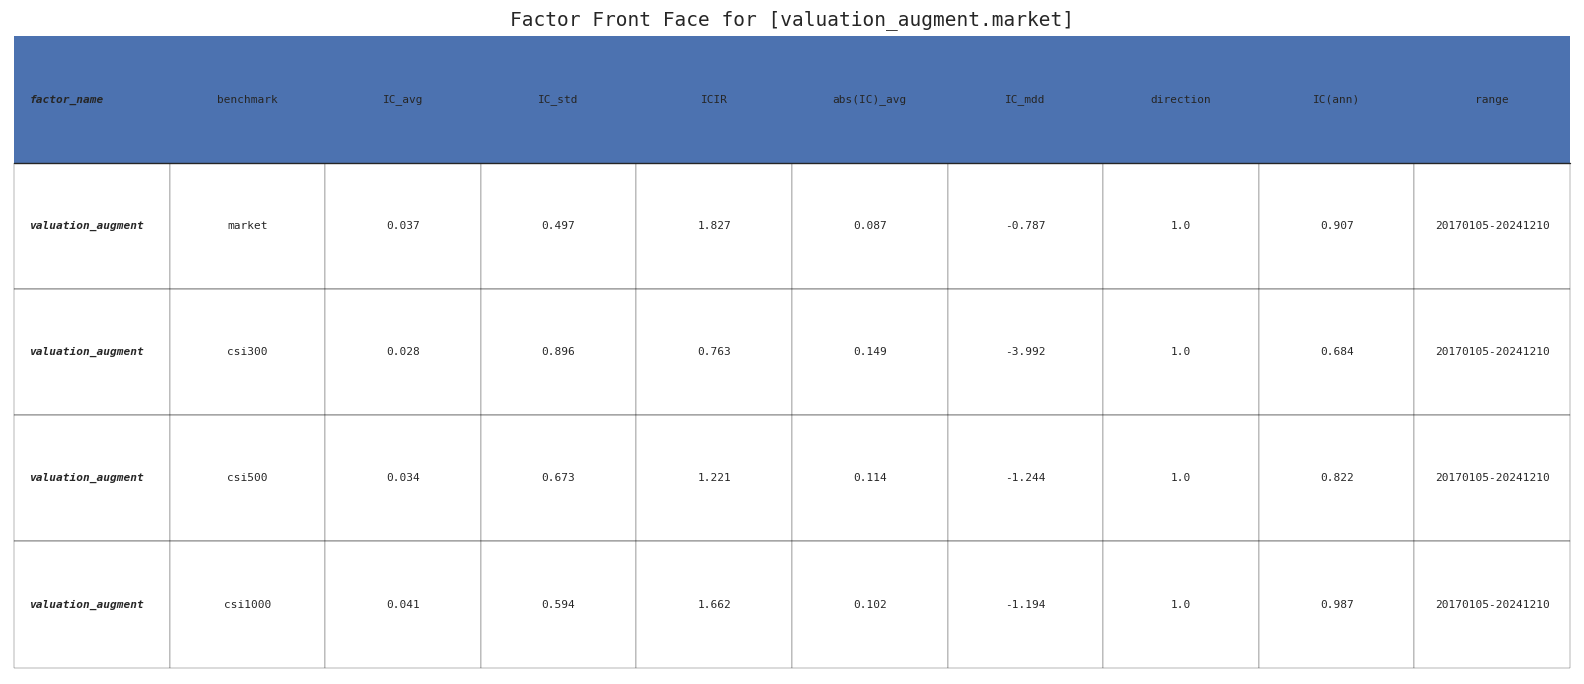

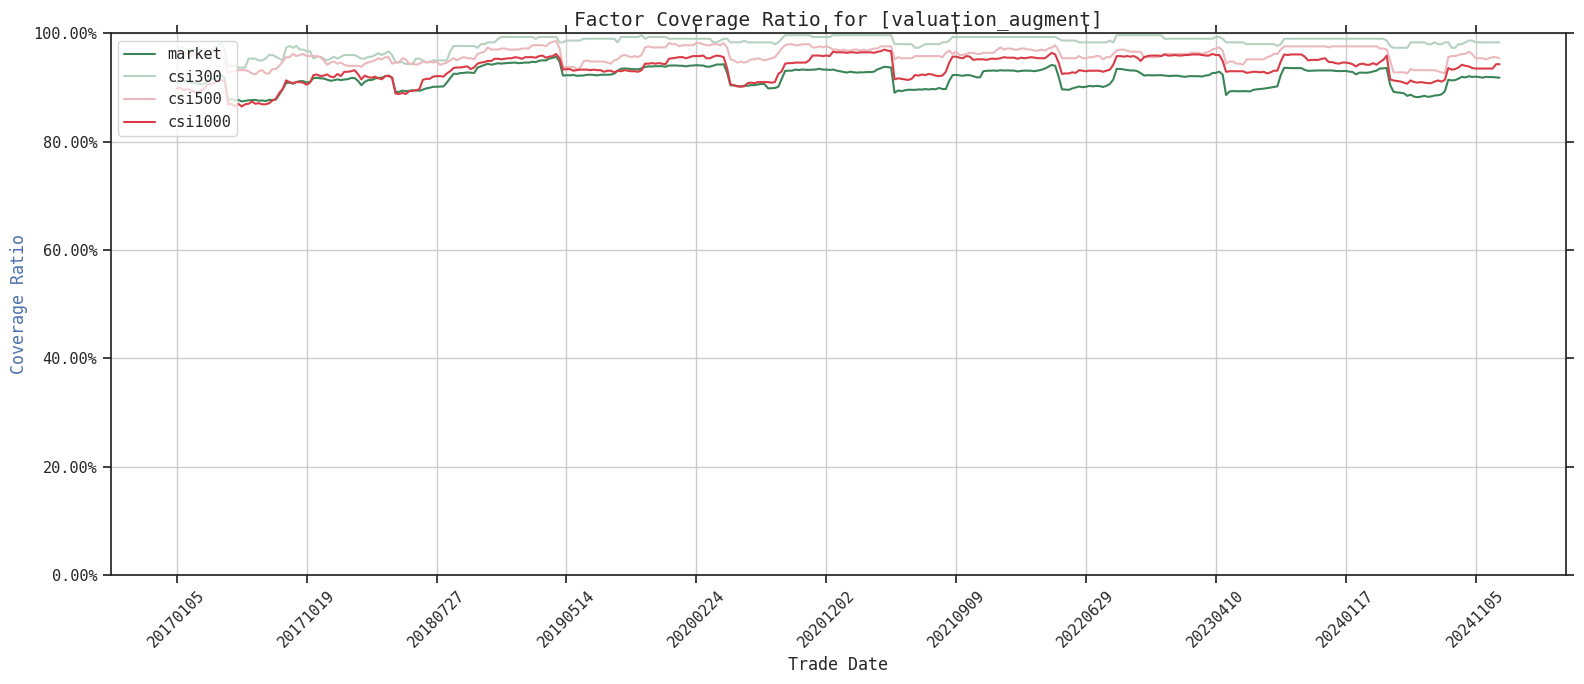

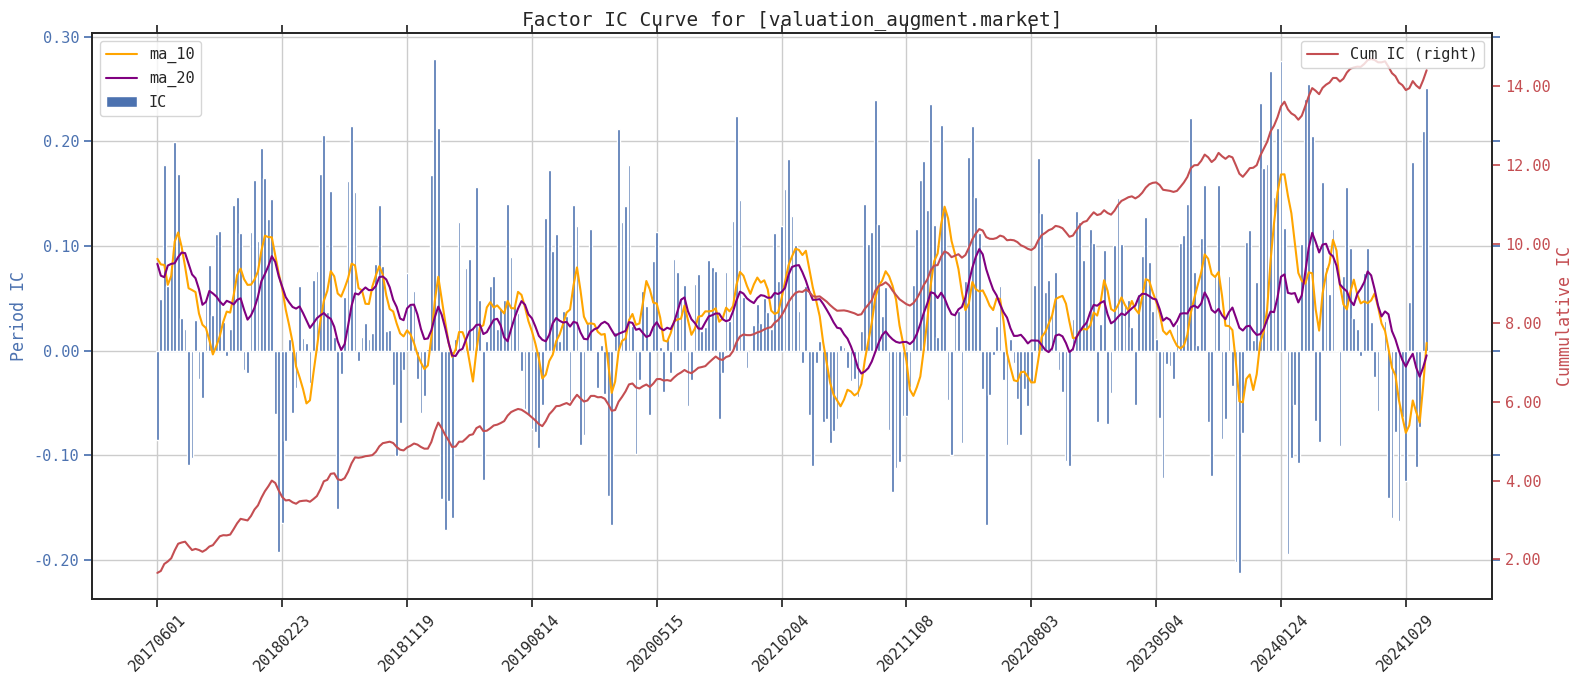

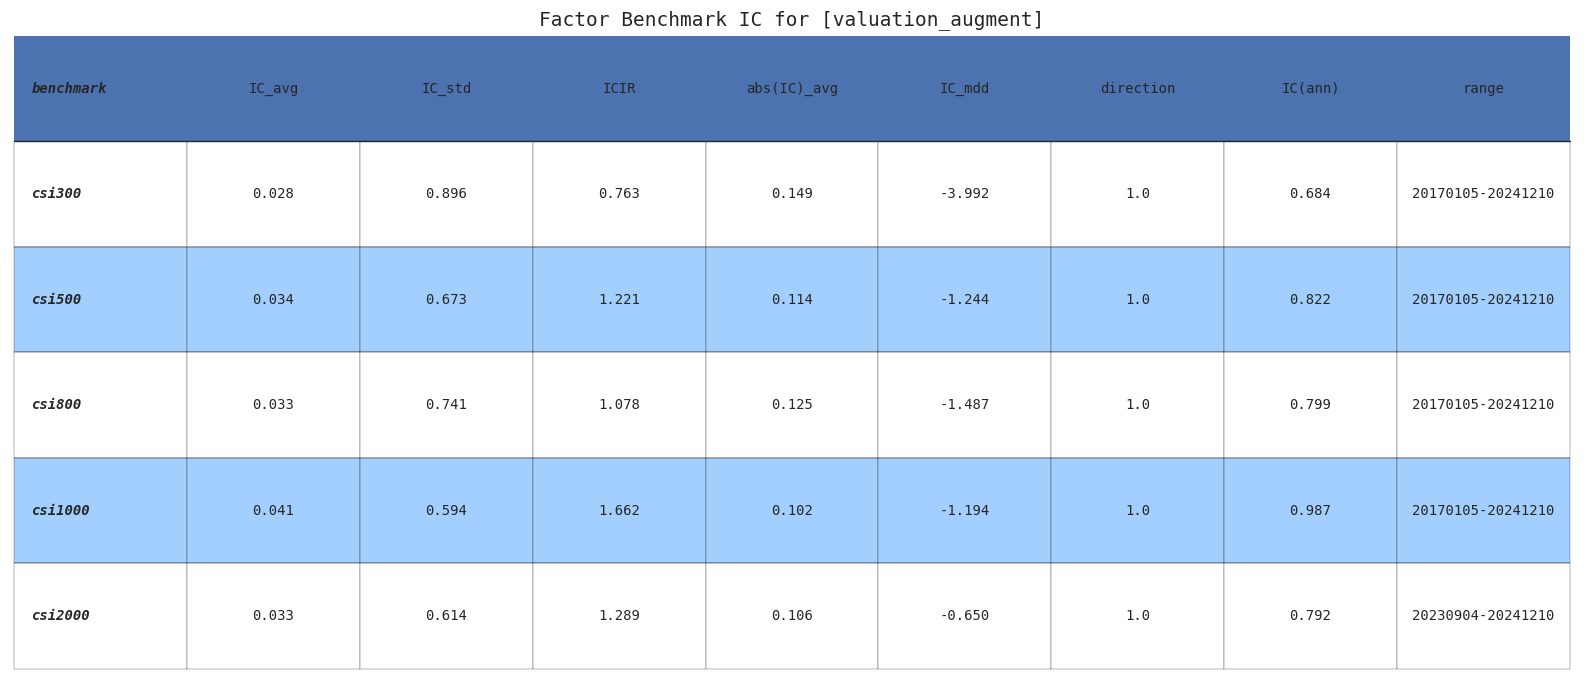

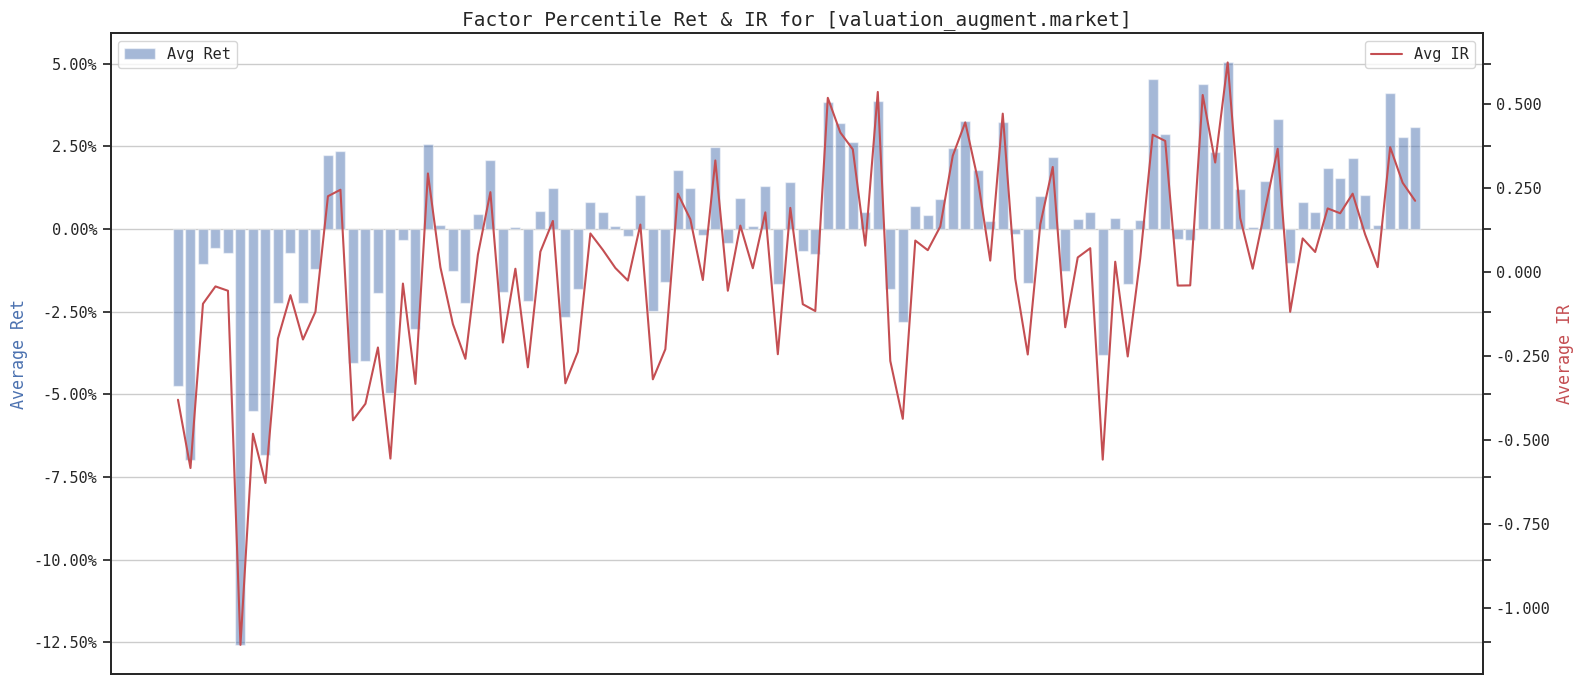

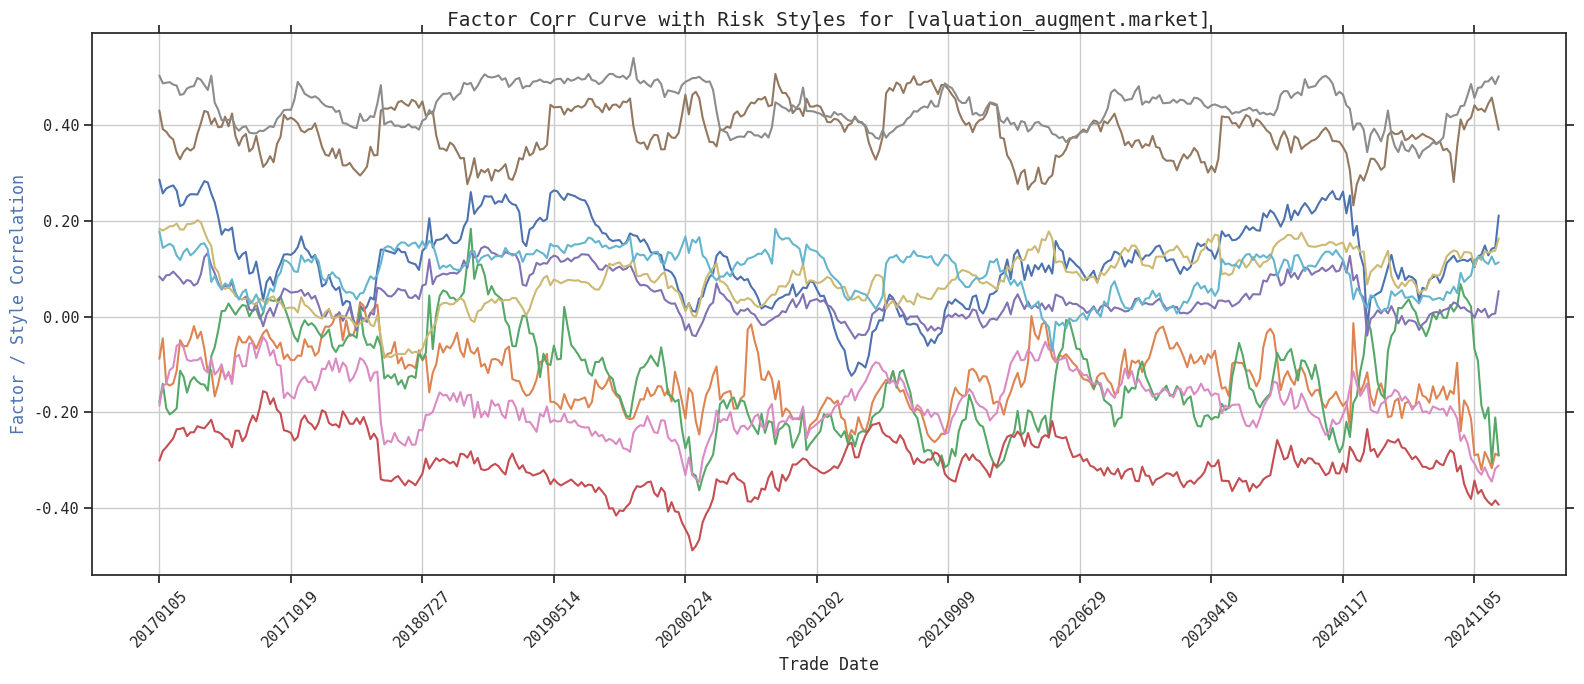

In [1]:
from src.api import FactorAPI
FactorAPI.FastAnalyze('valuation_augment' , start = 20170101 , step = 5 , lag = 1)


In [3]:
from src.factor.calculator import StockFactorHierarchy
hier = StockFactorHierarchy()
calcs = hier.iter_instance(**{})

In [1]:
from src.api import FactorAPI
hier = FactorAPI.Hierarchy()
hier.factor_df()['file_name'].unique()


src.INSTANCE_RECORD can be accessed to check ['trainer', 'account']
Basic module imported!


array(['analyst\\adjustment', 'analyst\\coverage', 'analyst\\forecast',
       'analyst\\surprise', 'behavior\\behavior_anndt',
       'behavior\\behavior_ff3', 'behavior\\behavior_slice',
       'behavior\\correlation_beta', 'behavior\\correlation_vp',
       'behavior\\liquidity_cap', 'behavior\\liquidity_cv',
       'behavior\\liquidity_illiquid', 'behavior\\liquidity_turnover',
       'behavior\\momentum_classic', 'behavior\\momentum_mdr',
       'behavior\\momentum_phigh', 'behavior\\momentum_weivol',
       'behavior\\volatility_exret', 'behavior\\volatility_ret',
       'behavior\\volatility_skew', 'fundamental\\earning_classic',
       'fundamental\\earning_sue', 'fundamental\\earning_tsreg',
       'fundamental\\growth_acc', 'fundamental\\growth_classic',
       'fundamental\\growth_long', 'fundamental\\growth_rankdelta',
       'fundamental\\growth_trend', 'fundamental\\growth_yoyzscore',
       'fundamental\\quality', 'fundamental\\valuation_dynamic',
       'fundamental\\va

In [2]:
factor_values = hier.test_calc_all_factors(ignore_error = False , verbose = True) # file_name = ''fundamental\\valuation_augment'' , 

uppct_npro_3m calculated , valid_ratio is 44.47%
upnum_npro_3m calculated , valid_ratio is 44.47%
upnum_npro_6m calculated , valid_ratio is 46.97%
rec_npro_3m calculated , valid_ratio is 44.47%
rec_npro_6m calculated , valid_ratio is 46.95%
upnum_npro_12m calculated , valid_ratio is 53.50%
cov_inst_3m calculated , valid_ratio is 100.00%
uppct_npro_12m calculated , valid_ratio is 53.50%
rec_npro_12m calculated , valid_ratio is 53.48%
cov_inst_12m calculated , valid_ratio is 100.00%
cov_report_3m calculated , valid_ratio is 100.00%
uppct_npro_6m calculated , valid_ratio is 46.97%
cov_inst_6m calculated , valid_ratio is 100.00%
cov_report_6m calculated , valid_ratio is 100.00%
cov_report_12m calculated , valid_ratio is 100.00%
upnum_npro_6m_anndt calculated , valid_ratio is 42.38%
rec_npro_6m_anndt calculated , valid_ratio is 42.35%
cov_inst_12m_anndt calculated , valid_ratio is 100.00%
uppct_npro_6m_anndt calculated , valid_ratio is 42.38%
eps_est_pct3m calculated , valid_ratio is 56.52%

In [ ]:
factor_values = hier.test_calc_all_factors(category0 = 'analyst' , multi_thread = True) # file_name = 'moneyflow/holding' , 

src.INSTANCE_RECORD can be accessed to check ['trainer', 'account']
Basic module imported!
etop_augment at 20241213 calculated
etop_augment at 20241115 calculated
etop_augment at 20241101 calculated
etop_augment at 20241129 calculated


StockFactor(normalized=False,names=['etop_augment'],dates=20241101-20241213)

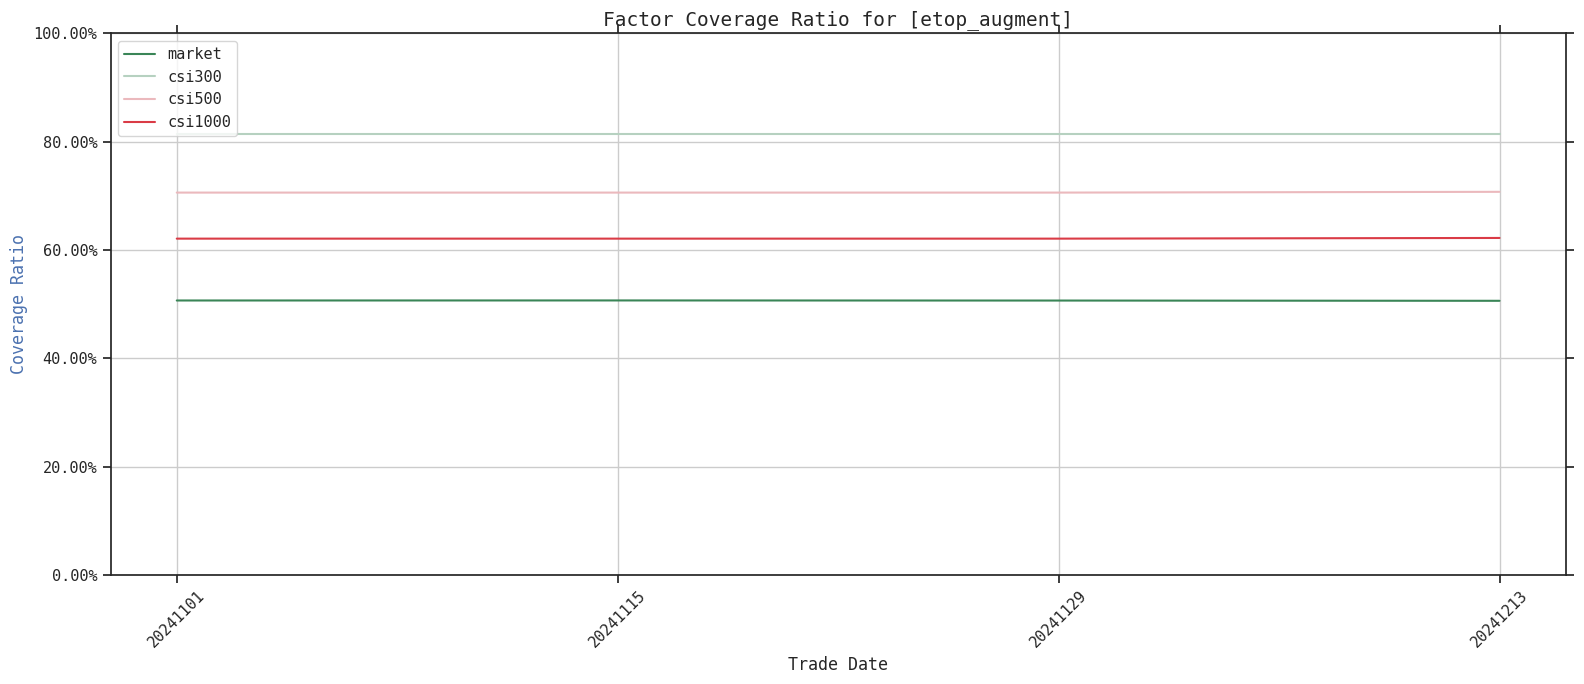

In [1]:
from src.api import FactorAPI
hier = FactorAPI.Hierarchy()
calc = hier.get_factor('etop_augment')
factor = calc.Factor(20241101 , multi_thread=True)
factor.analyze('Coverage')

In [7]:
hier.get_factor('ff_alpha_1m')().calc_factor(20241203)


secid
1         0.001472
2        -0.003134
4        -0.006647
6        -0.001304
7        -0.004757
            ...   
920088   -0.001742
920099    0.000018
920111    0.012260
920118    0.010361
920128   -0.002829
Name: ff_alpha_1m, Length: 5372, dtype: float64

In [2]:
from src_factor_definition.level1.fundamental.valuation_augment import btop_augment
btop_augment.Calc(20240620)

secid
1              NaN
2              NaN
4              NaN
6              NaN
7        -0.539658
            ...   
873706         NaN
873726   -0.173380
873806         NaN
873833         NaN
920002         NaN
Name: btop_augment, Length: 5365, dtype: float64

In [3]:
from src.factor.analytic.factor_perf.calculator import Factor_IC_Curve
calc = Factor_IC_Curve()
calc.calc(factor)
calc.calc_rslt

date        ic    cum_ic     ma_10     ma_20
factor_name  benchmark                                                  
btop_augment market     20240102  0.159530  0.159530       NaN       NaN
             market     20240116  0.184942  0.344472       NaN       NaN
             market     20240130 -0.029805  0.314667       NaN       NaN
             market     20240221 -0.159847  0.154820       NaN       NaN
             market     20240306 -0.015496  0.139324       NaN       NaN
...                          ...       ...       ...       ...       ...
             csi1000    20241021  0.016872  0.441610  0.031856  0.022080
             csi1000    20241104  0.178215  0.619825  0.053347  0.017056
             csi1000    20241118 -0.051258  0.568567  0.022584 -0.001386
             csi1000    20241202       NaN       NaN       NaN       NaN
             csi1000    20241216       NaN       NaN       NaN       NaN

[96 rows x 5 columns]

{'btop_augment.market': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi300': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi500': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi1000': <Figure size 1600x700 with 2 Axes>}

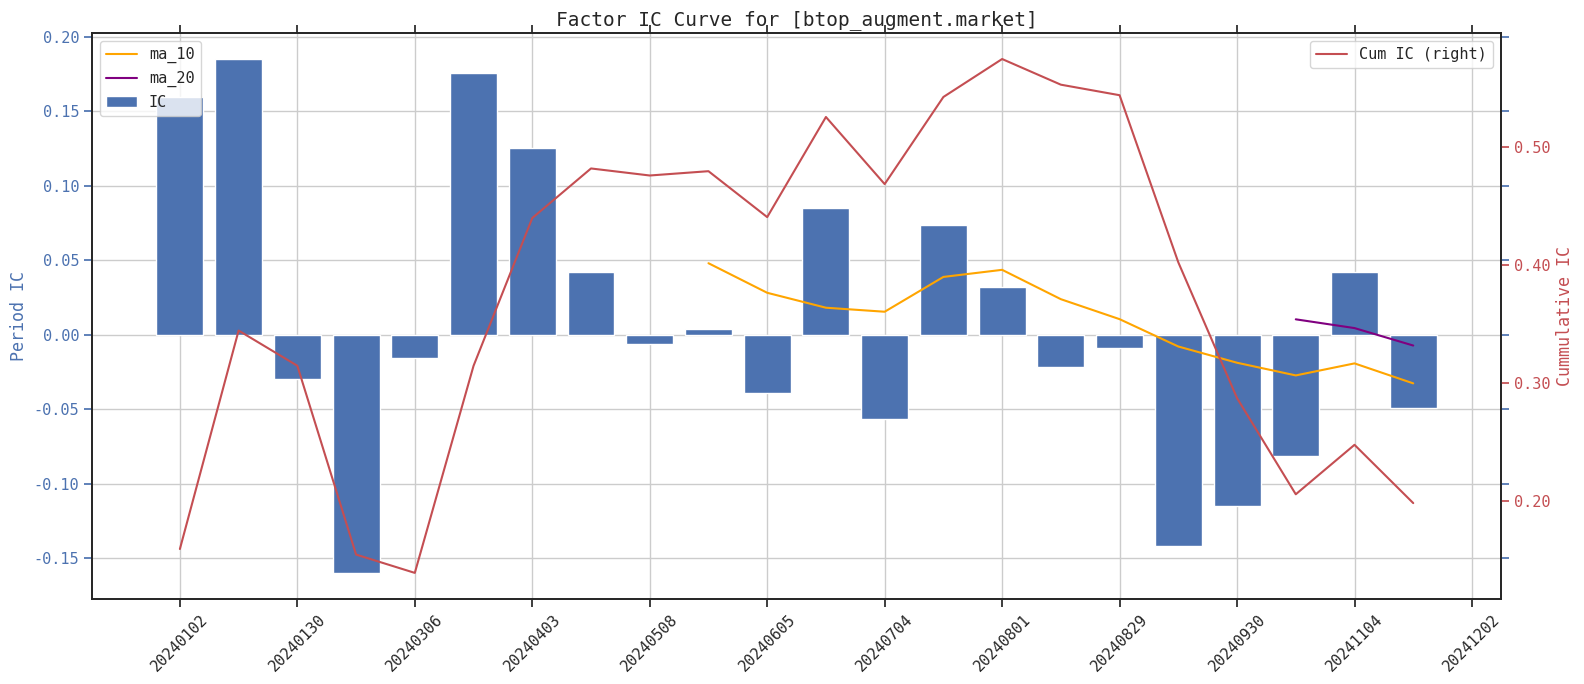

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from src.factor.util.plot import plot_table , get_twin_axes , set_xaxis , set_yaxis , PlotMultipleData , PlotFactorData , sns_lineplot , sns_barplot

def plot_factor_ic_curve(data : pd.DataFrame , show = False):
    group_plot = PlotMultipleData(data , group_key = ['factor_name' , 'benchmark'])
    for i , sub_data in enumerate(group_plot):     
        with PlotFactorData(sub_data , title = 'Factor IC Curve' , dropna = False , show=show and i==0) as (df , fig):
            df = df.set_index('date').sort_index()
            ax1 , ax2 = get_twin_axes(fig , 111)

            ax1.bar(df.index, df['ic'], color='b', label='IC')
            colors = ['orange','purple','olive','pink','cyan','grey','azure','yellow']
            for col in df.columns.tolist():
                if col.startswith('ma_'): ax1.plot(df.index, df[col], color=colors.pop(0) , label=col)  
            ax1.legend(loc='upper left')

            ax2.plot(df.index, df['cum_ic'], 'r-', label='Cum IC (right)')  
            ax2.legend(loc='upper right')  

            set_xaxis(ax1 , df.index)
            set_yaxis(ax1 , format='flt' , digits=2 , title = 'Period IC' , title_color='b' , tick_color='b')
            set_yaxis(ax2 , format='flt' , digits=2 , title = 'Cummulative IC' , title_color='r' , tick_color='r' , tick_pos=None)
            
    return group_plot.fig_dict

plot_factor_ic_curve(calc.calc_rslt , True)

StockFactor(normalized=True,names=['btop_augment'],dates=20240102-20241216)

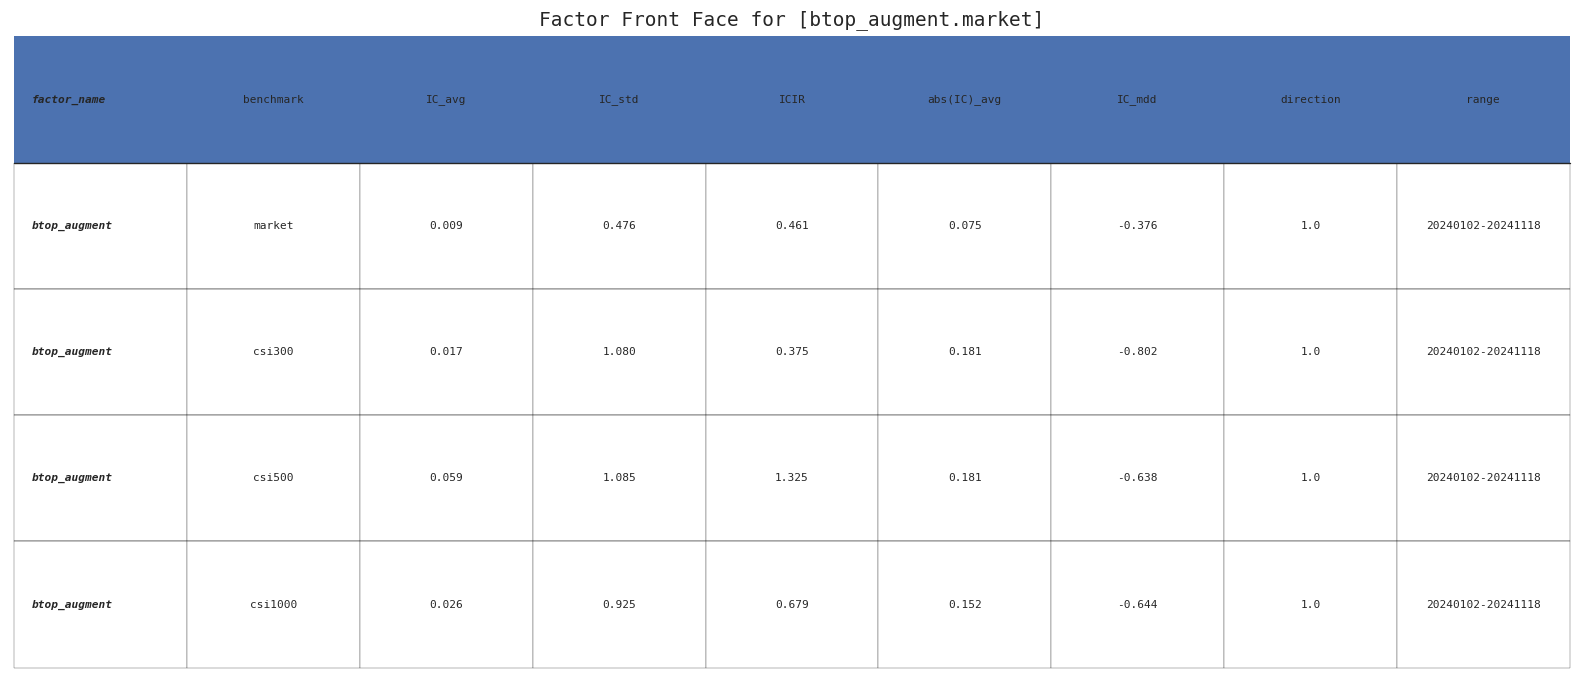

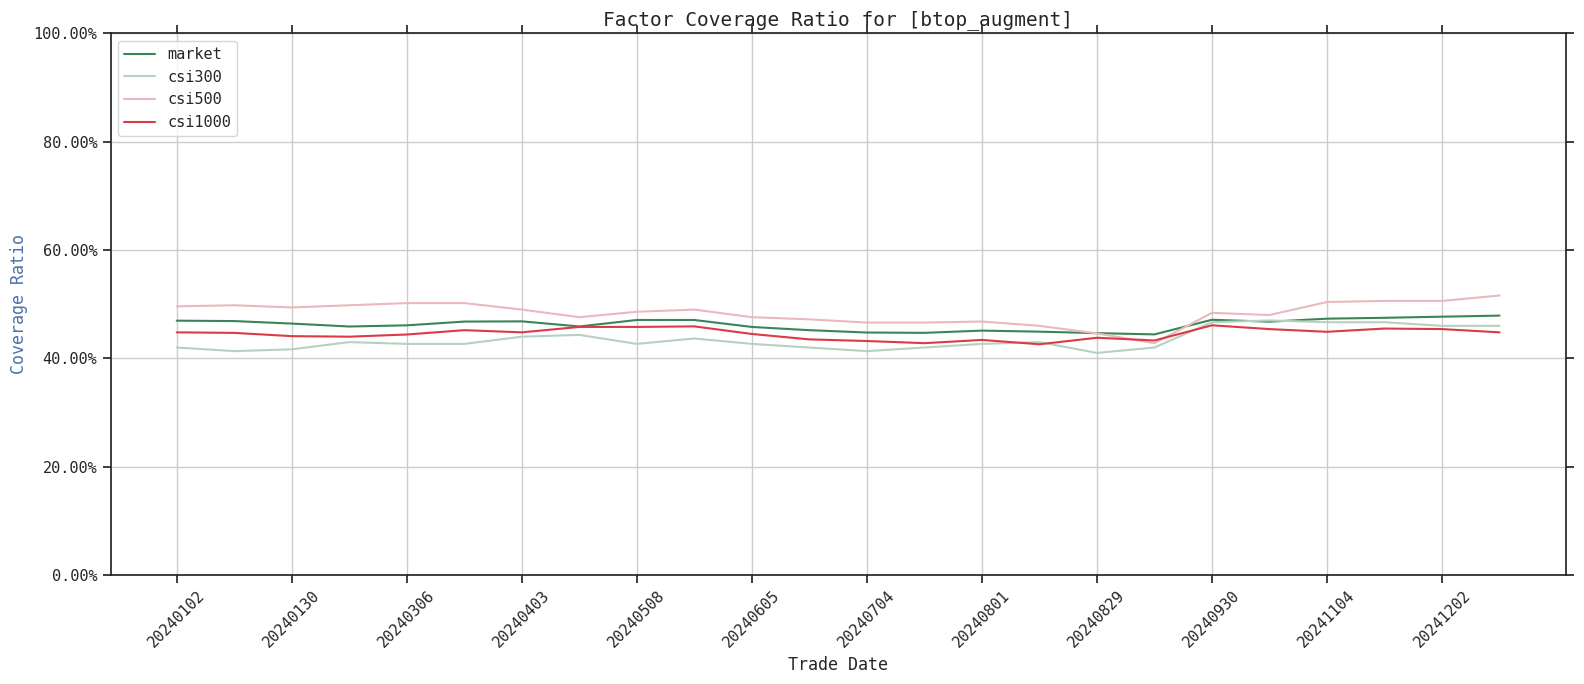

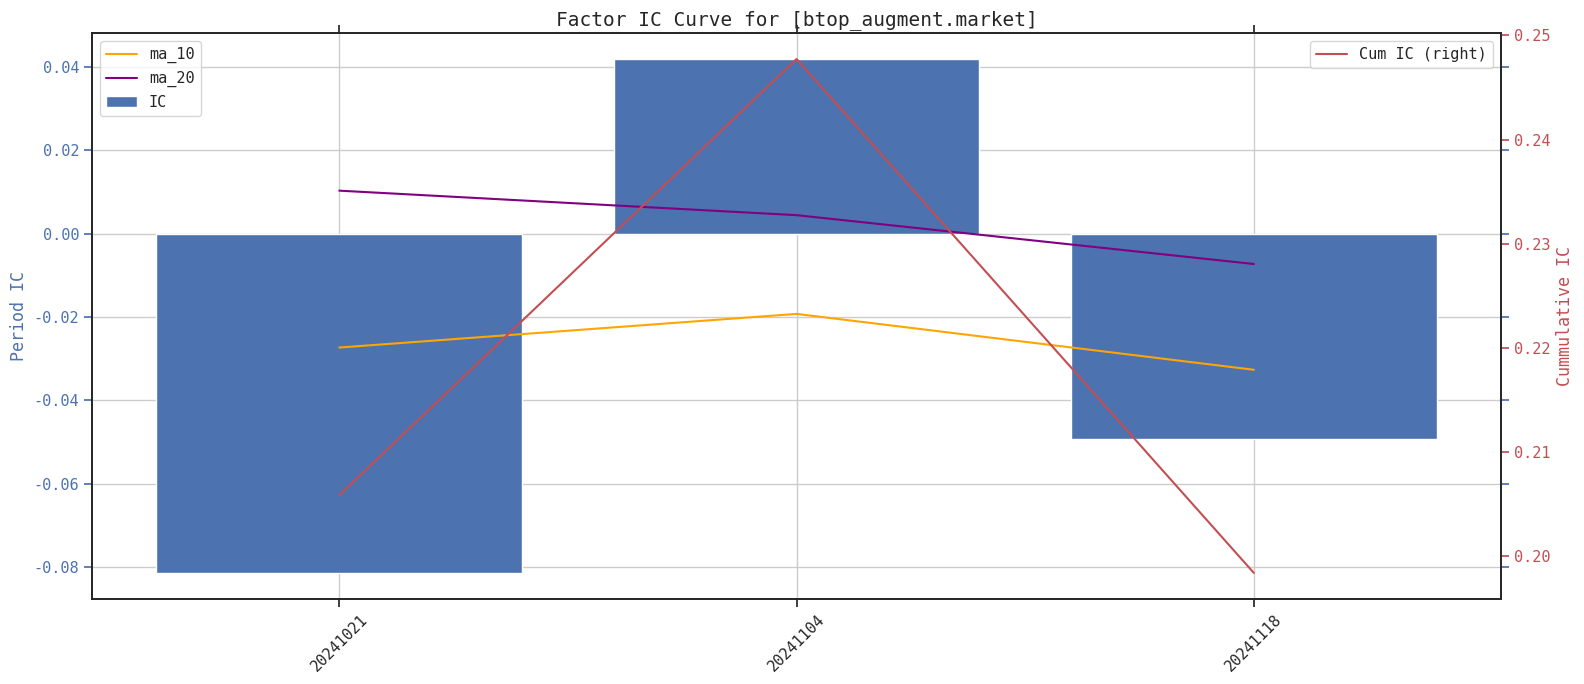

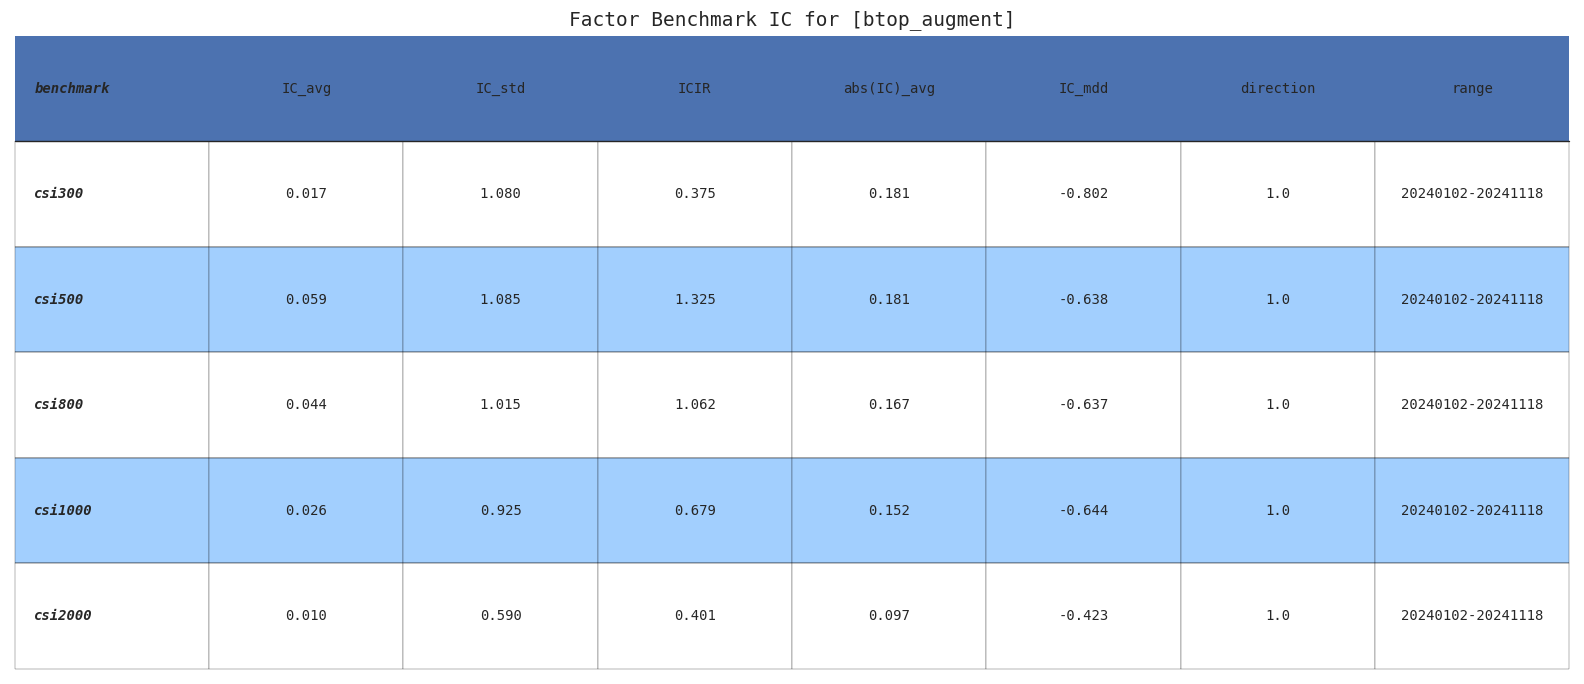

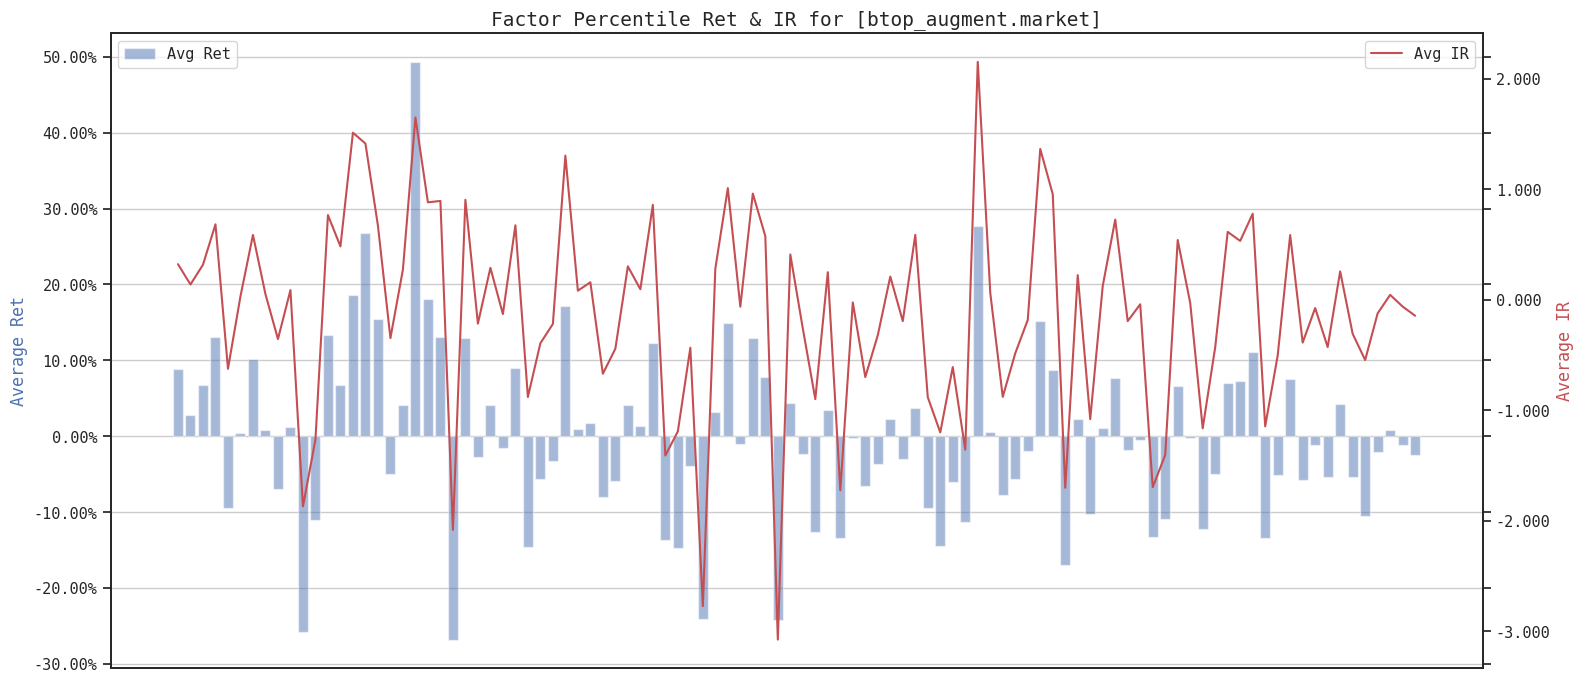

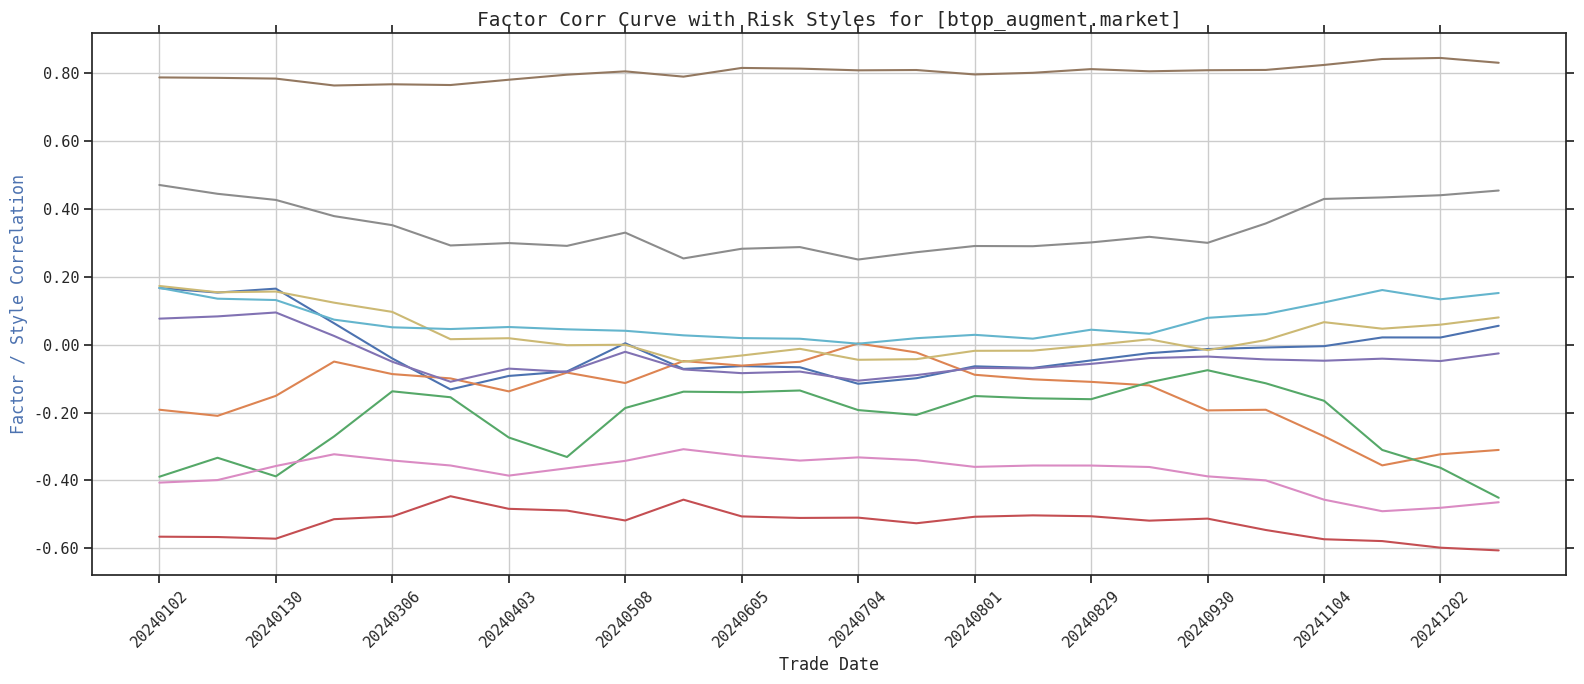

In [2]:
factor.fast_analyze()